In [67]:
import sys
sys.path.append("/vol/bitbucket/ad6013/Research/gp-causal")
import numpy as np
import matplotlib.pyplot as plt

import pickle

In [68]:
file_2 = "/vol/bitbucket/ad6013/Research/gp-causal/results/fullscore-sim-2-gplvm-sqexp-reinit20.p"


with open(file_2, "rb") as f:
    results_2 = pickle.load(f)

In [69]:
file_1 = "/vol/bitbucket/ad6013/Research/gp-causal/results/fullscore-sim-gplvm-sqexp-reinit20.p"


with open(file_1, "rb") as f:
    results_1 = pickle.load(f)

In [71]:
# log odds will be causal hypothesis over anticausal
scores_1 = {}
for idx, i in enumerate(results_1['scores']):
    if idx > 49:
        break
    causal = i[0]
    anti_causal = i[1]
    scores_1[idx] = (causal, anti_causal)
    if sum(causal) > sum(anti_causal):
        print(idx)

1
8
9
10
11
13
15
18
23
25
31
33
38
39
46
48


In [72]:
# log odds will be causal hypothesis over anticausal
scores_2 = {}
for idx, i in enumerate(results_2[1]):
    idx += 50
    causal = i[0]
    anti_causal = i[1]
    scores_2[idx] = (causal, anti_causal)
    if sum(causal) > sum(anti_causal):
        print(idx)

55
58
63
71
74
76
84
87


In [73]:
file_3 = "/vol/bitbucket/ad6013/Research/gp-causal/results/fullscore-sim-gplvm-sqexp-reinit5-numind110.p"


with open(file_3, "rb") as f:
    results_3 = pickle.load(f)

In [74]:
wrong = [1,
    8,
    9,
    10,
    11,
    13,
    15,
    18,
    23,
    25,
    31,
    33,
    38,
    39,
    46,
    48,
    55,
    58,
    63,
    71,
    74,
    76,
    84,
    87]
scores_3 = {}
for idx, i in enumerate(results_3['scores']):
    causal = i[0]
    anti_causal = i[1]
    scores_3[wrong[idx]] = (causal, anti_causal)

In [84]:
if 50 in scores_2.keys():
    print(1)

1


In [90]:
final_scores = {}
all_log_diffs = {}
correct_idx = []
wrong_idx = []
for i in range(100):
    if i in scores_3.keys():
        causal_x_3 = scores_3[i][0][0]
        causal_y_x_3 = scores_3[i][0][1]
        anticausal_y_3 = scores_3[i][1][0]
        anticausal_x_y_3 = scores_3[i][1][1]
        compare = True
    else:
        compare = False 
    if i in scores_1.keys():
        causal_x = scores_1[i][0][0]
        causal_y_x = scores_1[i][0][1]
        anticausal_y = scores_1[i][1][0]
        anticausal_x_y = scores_1[i][1][1]
    elif i in scores_2.keys():
        causal_x = scores_2[i][0][0]
        causal_y_x = scores_2[i][0][1]
        anticausal_y = scores_2[i][1][0]
        anticausal_x_y = scores_2[i][1][1]
    else:
        raise ValueError(f"{i} not found in results!")
    if compare:
        final_causal_x = min(causal_x, causal_x_3)
        final_causal_y_x = min(causal_y_x, causal_y_x_3)
        final_anticausal_y = min(anticausal_y, anticausal_y_3)
        final_anticausal_x_y = min(anticausal_x_y, anticausal_x_y_3)
    else:
        final_causal_x = causal_x
        final_causal_y_x = causal_y_x
        final_anticausal_y = anticausal_y
        final_anticausal_x_y = anticausal_x_y
    final_scores[i] = (
        (final_causal_x, final_causal_y_x),
        (final_anticausal_y, final_anticausal_x_y)
    )
    score_causal = final_causal_x + final_causal_y_x
    score_anticausal = final_anticausal_y + final_anticausal_x_y
    log_diff = score_causal - score_anticausal
    all_log_diffs[i] = log_diff
    if log_diff < 0:
        correct_idx.append(i)
    elif log_diff > 0:
        wrong_idx.append(i)
    else:
        print(
            f"Undecided: {i}"
        )


In [91]:
wrong_idx

[1, 8, 9, 10, 11, 13, 15, 23, 25, 31, 33, 38, 39, 55, 58, 71, 74, 76, 84, 87]

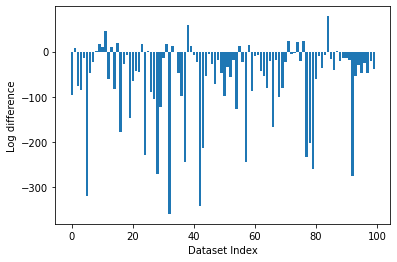

In [92]:
plt.bar(np.arange(len(all_log_diffs)), list(all_log_diffs.values()))
plt.ylabel("Log difference")
plt.xlabel("Dataset Index")
# plt.ylim(-400, 200)
plt.show()

In [93]:
# Calculate ROC curve and AUC 
# The score value should be - causal + anticausal
# This is because a higher score should mean causal and a lower score mean anticausal

# We also need to ensure half the labels are anticausal and half the labels are causal
# We thus need to generate indexes that will be the anticausal direction is true
# then for the other ones, we will multiply the scores by -1

anticausal_labels = np.random.choice(100, 50, replace=False)
causal_labels = np.array(
    list(
        set(np.arange(100)) - set(anticausal_labels)
    )
)
y_labels = np.zeros(100)
y_scores = np.zeros(100)
for i in range(100):
    if i in anticausal_labels:
        y_labels[i] = -1
        y_scores[i] = all_log_diffs[i]
    elif i in causal_labels:
        y_labels[i] = 1
        y_scores[i] = -1 * all_log_diffs[i]
    else:
        raise ValueError(f"Missed {i}")
    

In [94]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_curve, auc


fpr, tpr, _ = roc_curve(y_labels, y_scores)
roc_auc = auc(fpr, tpr)

In [95]:
roc_auc

0.8976

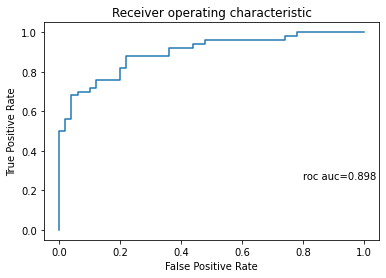

In [96]:
textstr = 'roc auc=%.3f\n'%(
    roc_auc
)
plt.text(0.8, 0.2, textstr, fontsize=10)
plt.plot(
    fpr, tpr
)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.show()

In [65]:
file = "/vol/bitbucket/ad6013/Research/gp-causal/results/fullscore-cep-gplvm-sqexp-reinit20.p"


with open(file, "rb") as f:
    results_tub = pickle.load(f)

In [66]:
corr, wrong, weight = results_tub["correct_idx"], results_tub["wrong_idx"], results_tub["weight"]
correct_weight = [weight[i] for i in corr]
wrong_weight = [weight[i] for i in wrong]
accuracy = np.sum(correct_weight) / (np.sum(correct_weight) + np.sum(wrong_weight))
print(f"\n Final accuracy: {accuracy}")


 Final accuracy: 0.6751023446222553


In [52]:
# log odds will be causal hypothesis over anticausal
log_odds_tub = []
for i in results_tub['scores']:
    causal = sum(i[0])
    anti_causal = sum(i[1])
    log_odds_tub.append(causal - anti_causal)

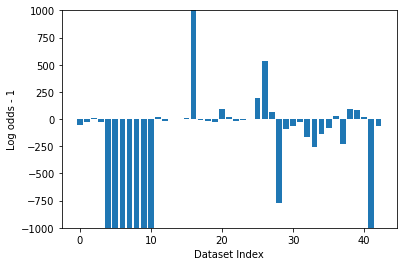

In [53]:
plt.bar(np.arange(len(log_odds_tub)), log_odds_tub)
plt.ylabel("Log odds - 1")
plt.xlabel("Dataset Index")
plt.ylim(-1000, 1000)
plt.show()

In [54]:
for idx, i in enumerate(log_odds_tub):
    print(
        f"{idx}, {i}"
    )


0, -58.76775580368246
1, -29.271284992371648
2, 5.444958032654995
3, -24.85126765075836
4, -6793.200733946684
5, -6791.042361109217
6, -3204.7850324804203
7, -3039.4245472529383
8, -3259.47271836702
9, -3258.417519880637
10, -3277.7193443540273
11, 18.309072591539007
12, -15.191325387190204
13, -3.0585648516163246
14, 3.348652760825644
15, 6.62747247219977
16, 9238.280529292864
17, -9.94984516822285
18, -15.494050632047674
19, -28.30637239151281
20, 94.65895082761631
21, 19.0851542336718
22, -21.773354030336804
23, -5.973443867824244
24, -2.655142919832997
25, 189.74702789557068
26, 529.873469576683
27, 66.12003965087115
28, -772.5473983240859
29, -90.46507534479179
30, -66.35001801947374
31, -23.445595758407535
32, -163.42221462529005
33, -256.4222602284218
34, -139.66086704732038
35, -78.10410591123707
36, 30.30972383912308
37, -230.4034228531914
38, 90.78074737329052
39, 84.92132219471614
40, 22.14295212223078
41, -1203.1253068311053
42, -66.21195299151259


In [55]:
Correct: 40, Wrong: 17
Correct: 42, Wrong: 8

SyntaxError: invalid syntax (300375016.py, line 1)

In [80]:
wrong_idx

[1,
 8,
 9,
 10,
 11,
 13,
 15,
 18,
 23,
 25,
 31,
 33,
 38,
 39,
 46,
 48,
 53,
 55,
 62,
 63,
 74,
 78,
 80,
 81,
 82,
 84,
 93,
 96]

Load cause-effect pairs: 100%|██████████| 100/100 [00:00<00:00, 240.94it/s]



 1: 7.947008861534641


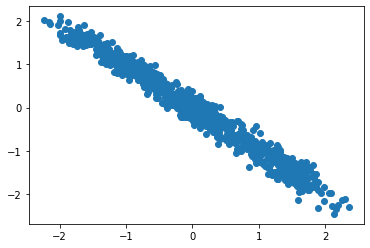


 8: 2.125546451411992


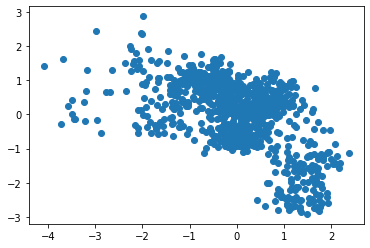


 9: 16.788658202864553


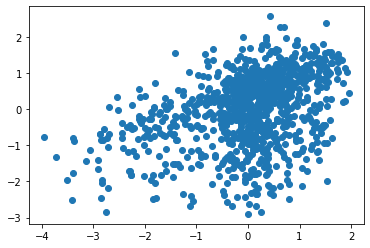


 10: 10.139711391789888


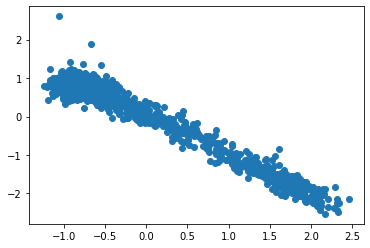


 11: 45.089589420741504


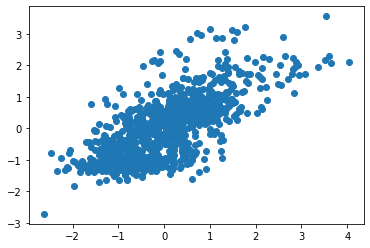


 13: 10.884235865943992


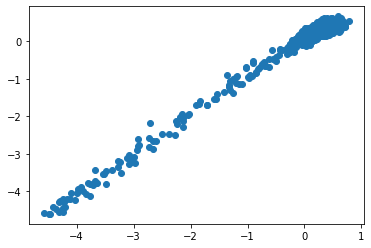


 15: 18.898060491425667


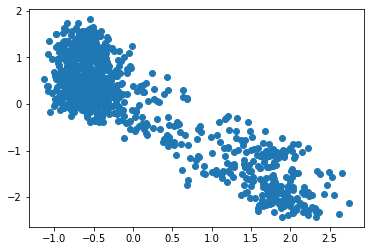


 23: 16.997171716323237


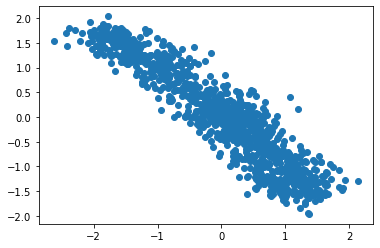


 25: 0.3289264679892767


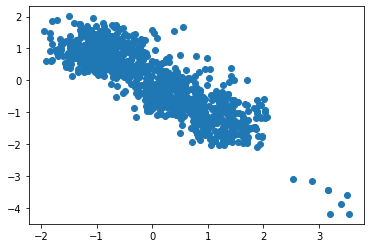


 31: 16.01142022572776


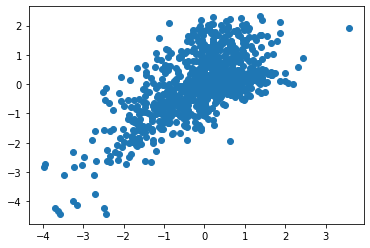


 33: 12.203888514887922


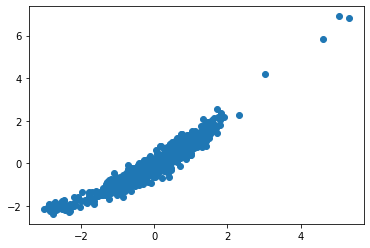


 38: 58.6196489362797


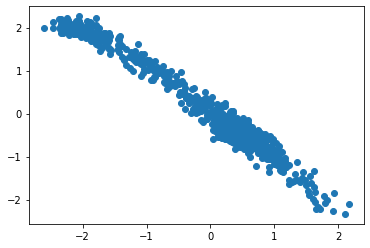


 39: 12.681931798781761


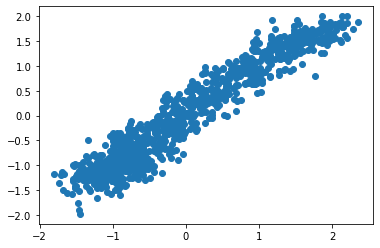


 53: 449.818798508335


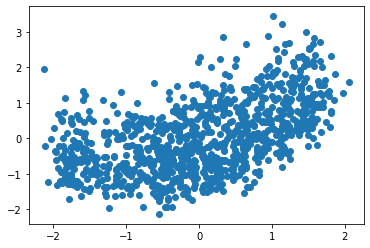


 55: 6.14180547240926


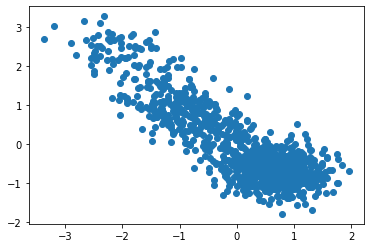


 58: 14.071561671170912


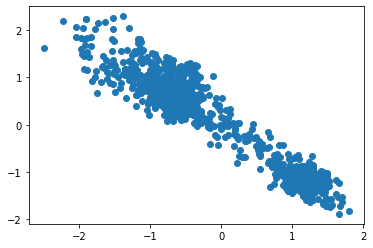


 62: 511.11743587693536


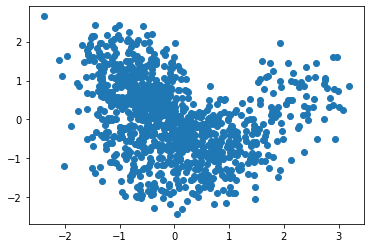


 63: 251.7880915671426


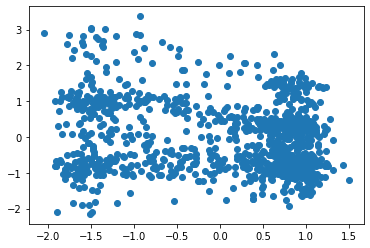


 71: 6.574690196946449


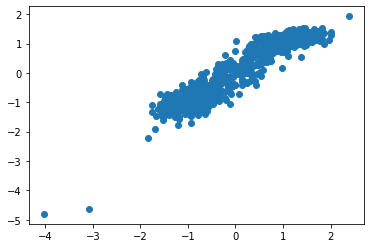


 74: 591.0919450068204


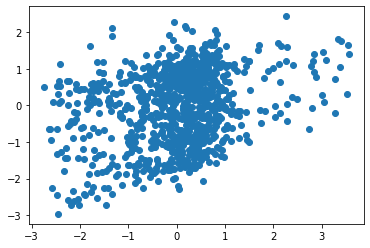


 78: 9.277580407200276


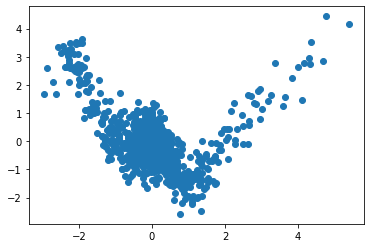


 80: 201.16551710876047


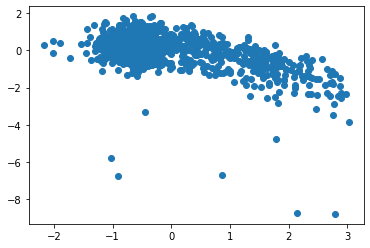


 81: 77.3423565119574


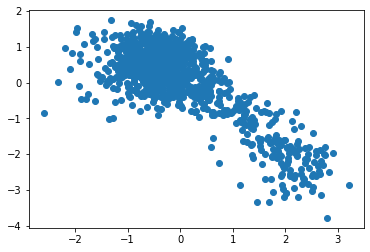


 82: 139.82388615749687


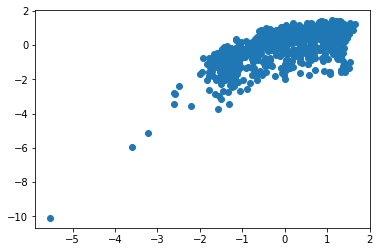


 84: 345.5727988656099


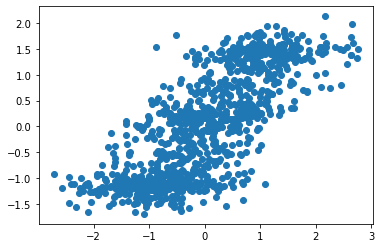


 93: 114.98187680688079


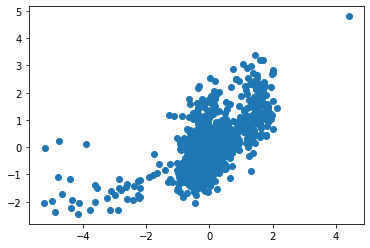


 96: 301.03152552818574


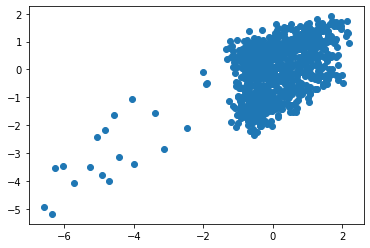

In [57]:
# Plot the results that we got wrong
from data.get_data import get_simulated_pairs_dataset


x, y, weight = get_simulated_pairs_dataset(
    data_path='/vol/bitbucket/ad6013/Research/gp-causal/data/sim_pairs/files'
)

for i in range(100):
    if i in wrong_idx:
        input, output = x[i], y[i]
        input = (input - input.mean(axis=0)[:, None]) / input.std(axis=0)[:, None]
        output = (output - output.mean(axis=0)[:, None]) / output.std(axis=0)[:, None]
        print(f"\n {i}: {all_log_diffs[i]}")
        plt.scatter(input[:, 0], output[:, 0])
        plt.show()